In [1]:
# import matplotlib.pyplot as plt
# from ultralytics import YOLO
# import cv2
# import google.generativeai as genai
# from PIL import Image, ImageDraw, ImageFont
# import numpy as np
# import time
# import os
from projectaria_tools.core import data_provider, calibration
import projectaria_tools.core.mps as mps
from projectaria_tools.core import data_provider
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.mps.utils import (
    get_gaze_vector_reprojection,
    get_nearest_eye_gaze
)
# import glob
from projectaria_tools.core.mps.utils import get_nearest_wrist_and_palm_pose
# import pandas as pd
import numpy as np
import cv2


In [2]:
gaze_cpf = mps.read_eyegaze('C:/Users/athen/Desktop/Github/MastersThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/eye_gaze/general_eye_gaze.csv')
handwrist_points  = mps.hand_tracking.read_wrist_and_palm_poses('C:/Users/athen/Desktop/Github/MastersThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/hand_tracking/wrist_and_palm_poses.csv')


timestamps = np.linspace(119.521, 136.771, 346)

res = {}

for t in timestamps:
  tns = t * 1e9

  wrist_and_palm_pose = get_nearest_wrist_and_palm_pose(handwrist_points, tns)

  if wrist_and_palm_pose is not None:
    left_pose_confidence = wrist_and_palm_pose.left_hand.confidence
    left_wrist_position_device = wrist_and_palm_pose.left_hand.wrist_position_device
    left_palm_position_device = wrist_and_palm_pose.left_hand.palm_position_device
    left_wrist_normal_device = wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device.wrist_normal_device

    res[t] = {
      'left_pose_confidence': left_pose_confidence,
      'left_wrist_position_device': left_wrist_position_device,
      'left_palm_position_device': left_palm_position_device,
      'left_wrist_normal_device': left_wrist_normal_device
    }





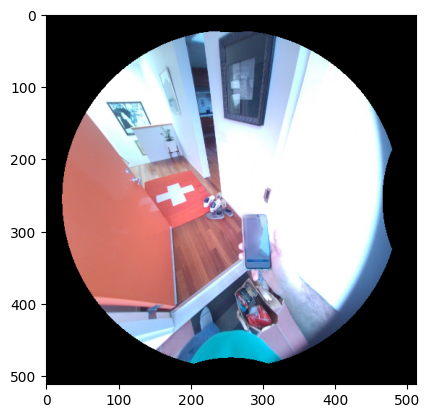

In [23]:
from projectaria_tools.core.calibration import (
    device_calibration_from_json_string,
    distort_by_calibration,
    get_linear_camera_calibration,
)
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.interpolate import griddata  # <-- Add this

# Load image and calibration
samp = cv2.imread('C:/Users/athen/Desktop/Github/MastersThesis/sampledata/sample1/rotated/214-1-00002-1658.460.jpg')
with open('C:/Users/athen/Desktop/Github/MastersThesis/MSc_AI_Thesis/Coding/other/calibration.json') as f:
    sc = f.read()

# Undistort image
sensors_calib = device_calibration_from_json_string(sc)
rgb_calib = sensors_calib.get_camera_calib("camera-rgb")
dst_calib = get_linear_camera_calibration(512, 512, 150, "camera-rgb")
undistorted_rgb_image = distort_by_calibration(samp, dst_calib, rgb_calib)
undistorted_rgb_image = cv2.cvtColor(undistorted_rgb_image, cv2.COLOR_BGR2RGB)

plt.imshow(undistorted_rgb_image)
plt.show()



# # Create mask for circular region
# h, w = 512, 512
# mask = np.ones((h, w), dtype=np.uint8)
# cv2.circle(mask, (w//2, h//2), min(w//2, h//2), 0, thickness=-1)

# # Identify missing pixels (0s inside the circle)
# gray = cv2.cvtColor(undistorted_rgb_image, cv2.COLOR_RGB2GRAY)
# missing_region = (gray == 0) & (mask == 0)  # Black pixels inside the circle

# # Extract coordinates of known pixels (valid data)
# known_coords = np.column_stack(np.where(~missing_region))  # (y, x) format
# yx_coords = np.column_stack(np.where(missing_region))      # Pixels to interpolate

# # Bicubic interpolation for each RGB channel
# interpolated = undistorted_rgb_image.copy()
# known_values = undistorted_rgb_image[~missing_region]  # Shape: (N, 3)

# # Convert coordinates to (x, y) format for griddata
# known_coords_xy = known_coords[:, [1, 0]]  # Swap columns to (x, y)
# yx_coords_xy = yx_coords[:, [1, 0]]        # Swap columns to (x, y)

# # Interpolate each channel (R, G, B)
# for c in range(3):
#     interpolated_vals = griddata(
#         known_coords_xy, 
#         known_values[:, c], 
#         yx_coords_xy, 
#         method='cubic', 
#         fill_value=0
#     )
#     interpolated[yx_coords[:, 0], yx_coords[:, 1], c] = interpolated_vals

# # Optional: Smooth with Gaussian blur
# interpolated = cv2.GaussianBlur(interpolated.astype(np.float32), (3, 3), 0).astype(np.uint8)

# # Display result
# plt.imshow(interpolated)
# plt.show()